## Contexte et Motivations
-> Collecte des données
->Enjeux "métiers"

## Préparation des données et visualisation
->Data Cleaning (Jointures, Outliers)
->Corrélations, Boxplots, Histogramme ...
->Train/Test/Valid

## Benchmark de méthodes
->RandomForest
->Régression linéaire
->Boosting
->GAM
->SVM
(->Clustering)

## Discussion des résultats
->Interprétation "métier"

# Introduction

Problème de classification multiclasse (3 classes)

Objectif : 
- Découvrir si les données d'évènements à la mi-temps permettent de prédire le résultat d'un match ;
- Déterminer s''il existe un modèle capable d'identifier le vainqueur d'un match.

# Contexte et Motivations

## Enjeux métiers



Objectifs : Prévisions de résultats de match de football en fonction des données des équipes (Equipes, Lineup ...)

## Collecte des données

L'ensemble des données ont été collectées via le package python statsbobmpy (openData).

In [44]:
from statsbombpy import sb

statsbombpy est un package python opensource permettant de récupérer différentes données de match de Football de différentes compétitions. l'API complète étant payante, nous nous concentrerons ici uniquement sur les données disponibles en OpenData.

La version OpenData du package ne permettant pas de récupérer des données groupées de manière accessibles, une grande partie de notre travail a consisté en la récupération et le nettoyage des données à notre disposition.

Le package consiste en 3 fonctions principales :
- sb.competitions() : permet de récupérer les identifiants de différentes compétitions, ainsi que différentes données par compétitions (compétition ,saison, genre, pays ...) ;
- sb.matches() : permet de récupérer les identifiants de matchs appartenant à une compétition et une saison donnée. Cette fonction permet aussi de récupérer des informations générales sur un match (équipes, scores, stade, arbitre ...). De cette fonction, seules les données d'équipes et de résultat de matchs nous intéresse ;
- sb.events() : permet de récupérer l'ensemble des évènements d'un match donné.

La fonction sb.events est la plus complète de ce package. En effet, chaque évènement est décrit par un type d'évènement (passe, tir, action du goal ...). Chacun de ces types d'évènements possèdent ses propres indicateurs, concernant notamment les identifiants du joueur effectuant l'action, la position de ce joueur, les autres évènements liés, le TimeStamp de l'évènement ... 

Dans un souci de simplicité, nous nous sommes concentrés sur l'obtention du nombre d'occurrence d'évènements de chaque type pour un match donné. N'ayant aucun a-priori sur les indicateurs significatifs pour notre problème, cette méthode nous semblait la plus simple à mettre en place, en espérant produire des résultats significatifs.

# Préparation des données et Visualisation

## Construction de la donnée cible

Avec l'impossibilité de récupérer directement les données agrégées, une grande partie de notre travail a été la récupération de ces données afin de créer le dataset d'intérêt "à la main".

In [5]:
###Bloc import des libraries
from statsbombpy import sb
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from os.path import exists

Regardons d'abord les indicateurs de compétitions à notre disposition en openData.

In [9]:
competitionData = sb.competitions()

In [10]:
competitionData.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
1,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-14T05:41:27.566989,None,None,2024-02-14T05:41:27.566989
2,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
3,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
4,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


Regardons les différentes compétitions à notre disposition :

In [11]:
competitionData['country_name'].unique()

array(['Germany', 'Africa', 'Europe', 'Spain', 'England', 'International',
       'India', 'Argentina', 'France', 'United States of America',
       'North and Central America', 'Italy'], dtype=object)

In [12]:
competitionData['competition_name'].unique()

array(['1. Bundesliga', 'African Cup of Nations', 'Champions League',
       'Copa del Rey', "FA Women's Super League", 'FIFA U20 World Cup',
       'FIFA World Cup', 'Indian Super league', 'La Liga',
       'Liga Profesional', 'Ligue 1', 'Major League Soccer',
       'North American League', 'NWSL', 'Premier League', 'Serie A',
       'UEFA Euro', 'UEFA Europa League', "UEFA Women's Euro",
       "Women's World Cup"], dtype=object)

Dans le dataset disponible en openData, nous avons donc à notre disposition différentes compétitions (masculines/féminines, jeune, nationale/internationale) des principaux pays dans le monde du Football (Europe, Amérique ...). Afin de récupérer le maximum de données, nous avons choisi de sélectionner l'ensemble des compétitions à notre disposition.

Regardons un exemple de matchs à notre disposition, pour une compétition donnée (Bundesliga 2015/2016).

In [13]:
matchStats = sb.matches(competition_id=9, season_id=27)

In [14]:
matchStats.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3890561,2016-05-14,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hoffenheim,Schalke 04,1,4,available,...,None,34,Regular Season,PreZero Arena,Felix Brych,Julian Nagelsmann,André Breitenreiter,1.1.0,2,2
1,3890505,2016-04-02,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Bayern Munich,Eintracht Frankfurt,1,0,available,...,None,28,Regular Season,Allianz Arena,Florian Meyer,Josep Guardiola i Sala,Niko Kovač,1.1.0,2,2
2,3890511,2016-04-08,20:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,Hannover 96,2,2,available,...,None,29,Regular Season,Olympiastadion Berlin,Benjamin Brand,Pál Dárdai,Daniel Stendel,1.1.0,2,2
3,3890515,2016-04-09,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hamburger SV,Darmstadt 98,1,2,available,...,None,29,Regular Season,Volksparkstadion,Peter Sippel,Bruno Labbadia,Dirk Schuster,1.1.0,2,2
4,3890411,2015-12-20,16:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,FSV Mainz 05,2,0,available,...,None,17,Regular Season,Olympiastadion Berlin,Peter Sippel,Pál Dárdai,Martin Schmidt,1.1.0,2,2


Pour une compétition données, seules les premières colonnes nous sont essentielles pour notre problème : home_team, away_team, home_score, away_score.

De ces données, nous pouvons alors classifier chaque match dans 3 catégories : Home Win, Away Win, Draw.

De ce dataset, nous pouvons donc construire notre target : Pour chaque match de chaque compétition, il nous faut alors déterminer le vainqueur de chaque match en comparant leurs scores. 

In [15]:
### Création de la fonction de détermination du vainqueur
def result(row):
    resultLabel = ""

    if row['home_score'] > row['away_score']:
        resultLabel = "Home"

    elif row['home_score'] < row['away_score']:
        resultLabel = "Away"

    else:
        resultLabel = "Draw"

    return resultLabel



Nous allons maintenant construire le dataset de covariables pour chaque match.

## Construction des variables

Objectifs : 
- Récuperer pour chaque compétition chaque match (par son identifiant) ;
- Pour chaque match, récupérer le nombre d'évènements à la mi-temps.

On va d'abord construire l'ensemble des comptes d'évènements pour une compétition donnée :

In [16]:
#Variables disponibles dans le package statsbomb
EVENT_NAMES = ["Ball Receipt*", "Ball Recovery", "Dispossessed", "Duel", "Block", "Offside", "Clearance", "Interception", "Dribble", "Shot", "Pressure", "Substitution", "Own Goal Against", "Foul Won", "Foul Committed", "Goal Keeper", "Bad Behaviour", "Player On", "Player Off", "Shield", "Pass", "50/50", "Tactical Shift", "Error", "Miscontrol", "Dribbled Past", "Injury Stoppage", "Referee Ball-Drop", "Carry"]


def oneCompetionEventsCount(competitionId, seasonId):
        
    try :
        ##On récupère l'ensemble des matchs de la compétition
        matchStats = sb.matches(competition_id= competitionId, season_id= seasonId)

        #On récupère les colonnes utiles pour déterminer la colonne cible
        matchStats = matchStats[['match_id', 'home_team', 'away_team', 'home_score', 'away_score']]

        #On crée la colonne cible
        matchStats['Result'] = matchStats.apply(result, axis = 1)

        #On indexe par matchId (unique)
        matchStats.set_index('match_id', inplace=True)

        for matchId in matchStats.index:
            #Récupérer tout les events du matchs
            matchEventFull = sb.events(match_id = matchId)

            #Ne conserver que ceux pour lesquels period = 1 (1ere mi-temps)
            matchEventFull = matchEventFull.loc[matchEventFull['period'] == 1]

            #On compte le nombre d'occurences de chaque event par équipe
            eventCountByTeam = matchEventFull.groupby(by=['team', 'type'])['type'].count().unstack(level=1)

            #On récupère les noms de chaque équipe
            homeTeamName = matchStats.loc[matchId,'home_team']
            awayTeamName = matchStats.loc[matchId,'away_team']


            #On ajoute les colonnes features intéressantes au dataframe matchStats
            for name in EVENT_NAMES:
                matchStats.loc[matchId, "Home-" + name] = eventCountByTeam.loc[homeTeamName, name] if name in eventCountByTeam.loc[homeTeamName].index else 0
                matchStats.loc[matchId, "Away-" + name] = eventCountByTeam.loc[awayTeamName, name] if name in eventCountByTeam.loc[awayTeamName].index else 0

            
            ###Si valeurs manquantes, on rempli les valeurs vides de 0 (Evenement non rencontré)
            matchStats.fillna(0, inplace= True)

        #On crée le dataset "final"
        matchStats = matchStats.iloc[:, 4:]
        target = matchStats['Result']
        matchStats = matchStats.iloc[:,1:].astype(int)

        return matchStats, target
    except:
        #Message d'erreur
        print("Erreur dans la fonction oneCompetitionEventsCount")    


On peut alors boucler sur l'ensemble des compétitions pour construire les datasets finaux. Afin d'éviter de recréer les datasets à chaque fois, on les stockes dans un fichier .csv externe.

In [17]:
def allCompetitionEventsCount():
    try :
        #Si le fichier existe déjà, inutile de le recréer
        if exists("Data/fullMatchData.csv") & exists("Data/fullTargetData.csv"):
            return pd.read_csv("Data/fullMatchData.csv"), pd.read_csv("Data/fullTargetData.csv")
        
        else:
            
            #On récupère l'ensemble des compétitions
            competitionData = sb.competitions()

            #On initialise les dataframes
            fullMatchData = pd.DataFrame()
            fullTargetData = pd.DataFrame()

            #On boucle sur l'ensemble des compétitions
            for idx in competitionData.index:
                
                #On récupère les Ids nécessaires identifier une compétition
                competitionId, seasonId = competitionData.loc[idx, ['competition_id', 'season_id']]

                #On construit les datasets de variables/targets pour cette compétition
                matchData, target = oneCompetionEventsCount(competitionId, seasonId)

                #On les ajoute aux datasets globaux
                fullMatchData = pd.concat([fullMatchData, matchData], sort= False)
                fullTargetData = pd.concat([fullTargetData, target])

            #Dans le cas ou des évènements seraient manquants, on complète les valeurs vides par 0
            fullMatchData.fillna(0, inplace= True)

            #On stocke les datasets finaux
            fullMatchData.to_csv("Data/fullMatchData.csv", index= False)
            fullTargetData.to_csv("Data/fullTargetData.csv", index= False)

            return fullMatchData, fullTargetData


    except:
        print("Erreur dans la fonction allCompetitionEventsCOunt")

In [18]:
fullMatchData, fullTargetData = allCompetitionEventsCount()

#### Expliquer shape

In [19]:
fullMatchData.shape

(3316, 58)

In [20]:
fullMatchData.head()

,Home-Ball Receipt*,Away-Ball Receipt*,Home-Ball Recovery,Away-Ball Recovery,Home-Dispossessed,Away-Dispossessed,Home-Duel,Away-Duel,Home-Block,Away-Block,...,Home-Miscontrol,Away-Miscontrol,Home-Dribbled Past,Away-Dribbled Past,Home-Injury Stoppage,Away-Injury Stoppage,Home-Referee Ball-Drop,Away-Referee Ball-Drop,Home-Carry,Away-Carry
0,241,262,23,19,4,5,14,11,12,10,...,12,7,2,3,1,2,0,0,224,204
1,322,178,23,27,3,5,21,18,7,1,...,6,8,2,3,1,2,2,2,251,102
2,342,141,19,24,4,3,14,22,7,10,...,9,14,7,5,1,0,0,0,292,126
3,304,130,30,20,6,4,18,24,5,7,...,7,5,5,3,1,1,1,1,246,81
4,379,160,25,15,5,3,11,20,11,8,...,5,5,3,4,1,0,0,0,305,110


On obtient alors un dataset de taille raisonnable, 3316 observations de 58 variables numériques entières. De manière prévisible, certaines variables sont nettement plus élevées que d'autres en moyenne, certains évènements intervenant de manière beaucoup plus fréquente que d'autres ; ceci justifie l'utilisation d'un Scaler dans les différents modèles évalués.

# Data Visualization

Avant d'implémenter les modèles de classification, on va d'abord s'attaquer à la visualisation des données, afin de repérer certaines variables significatives.

## Corrélation entres variables

<Axes: >

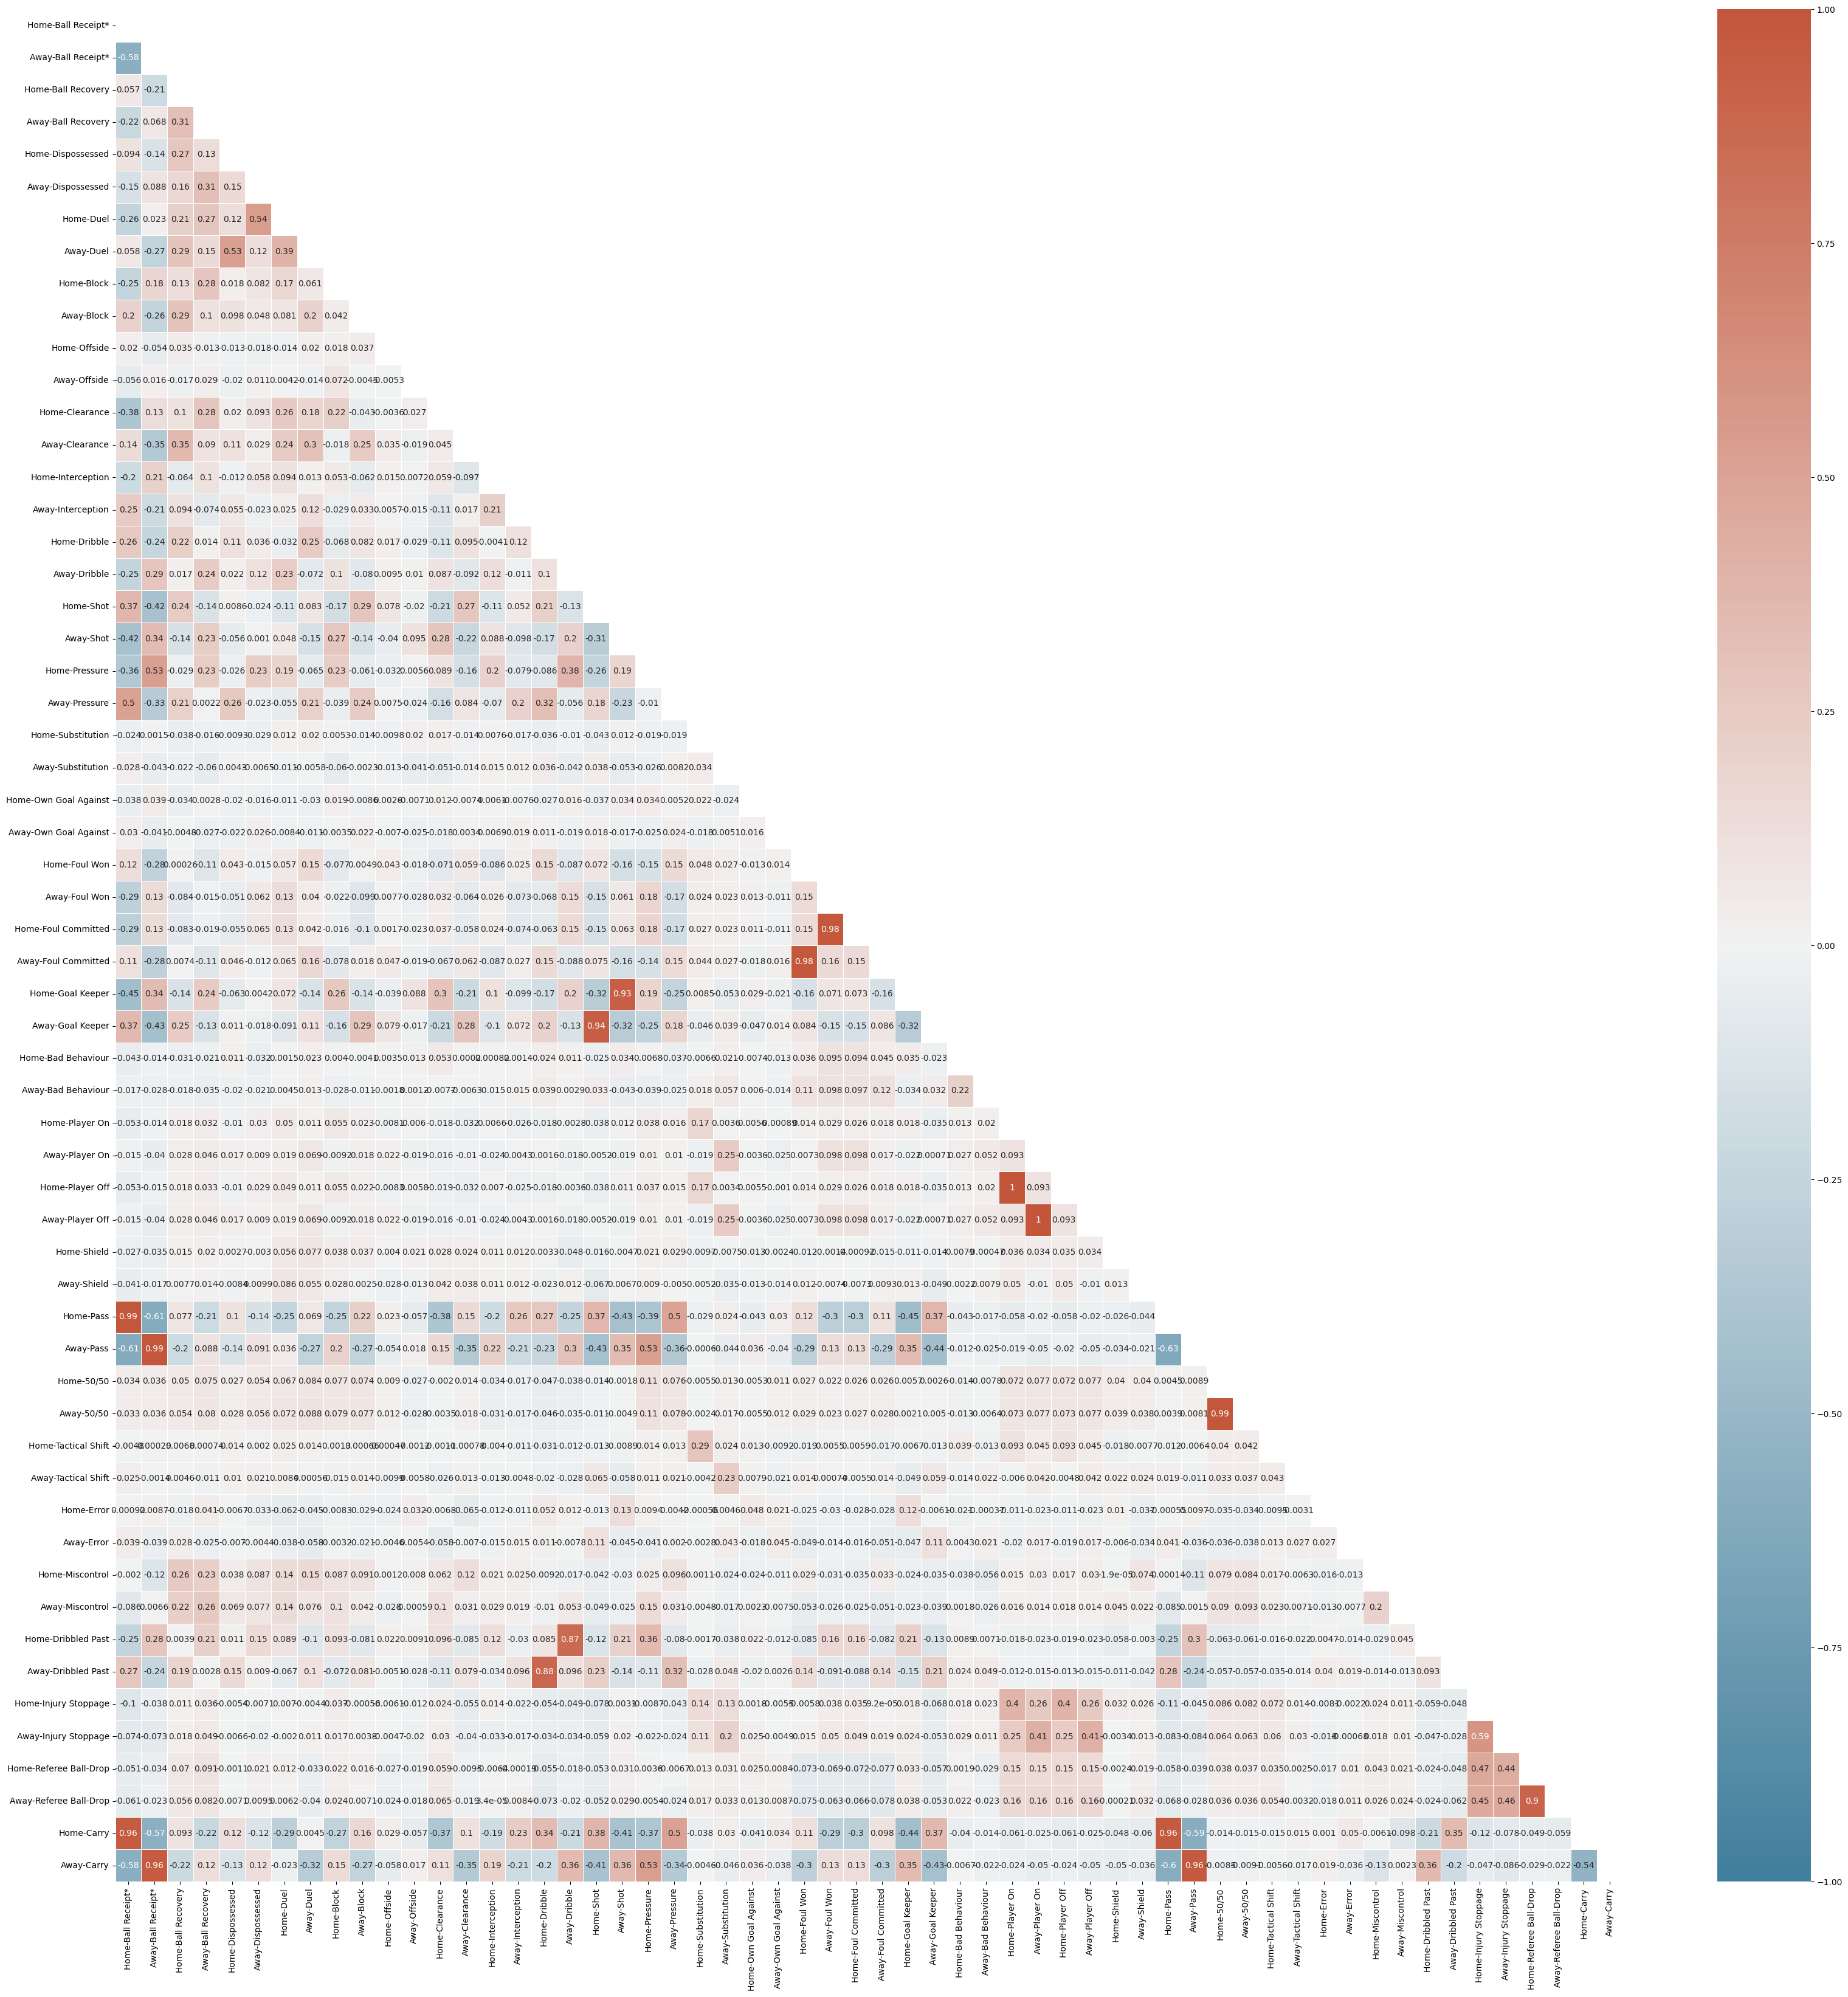

In [21]:
#Palette de contraste
COLOR_MAP = sns.diverging_palette(230, 20, as_cmap=True)

#Figure matplotlib
fig, ax = plt.subplots(figsize= (40,40))
#
sns.heatmap(fullMatchData.corr(), #Plot de la matrice de corrélation 
            mask = np.triu(np.ones_like(fullMatchData.corr(), dtype = bool)), #On n'affiche que la partie triangulaire inférieure de la matrice de corrélation
            cmap = COLOR_MAP,
            annot = True, #On affiche les valeurs du coeeficient de corrélation
            linewidths = .5,
            vmin = -1,
            vmax = 1)

On peut alors remarquer que certaines variables sont très fortement corrélées entre elles ; en regard de la dénomination de ces variables, cela n'a rien d'étonnant. En effet, on remarque que le nombre de passe d'un match est fortement corrélés avec une possesion de balle élevée, qu'un 50/50 se joue toujours entre une équipe et l'équipe adverse, ou qu'un retrait de joueur sur le terrain et toujours accompagné d'une entrée de joueur. On remarque également qu'un tir d'une équipe et accompagné d'une action du goal de l'équipe adverse.

Aucune variable ne se trouve être parfaitement négativement corrélées, mais certaines interactions sont à remarquer : Le nombre de réception de passe est négativement corrélés au nombre d'actions du goal d'une équipe, le nombre de passe d'une équipe est négativement corrélés au nombre de passes de l'équipe adverse ...

La plupart des autres variables ne semblent pas avoir d'interactions linéaires entres elles, mais regardons maintenant comment cela se comporte vis-à-vis des résultats des matchs.

## Visualisations

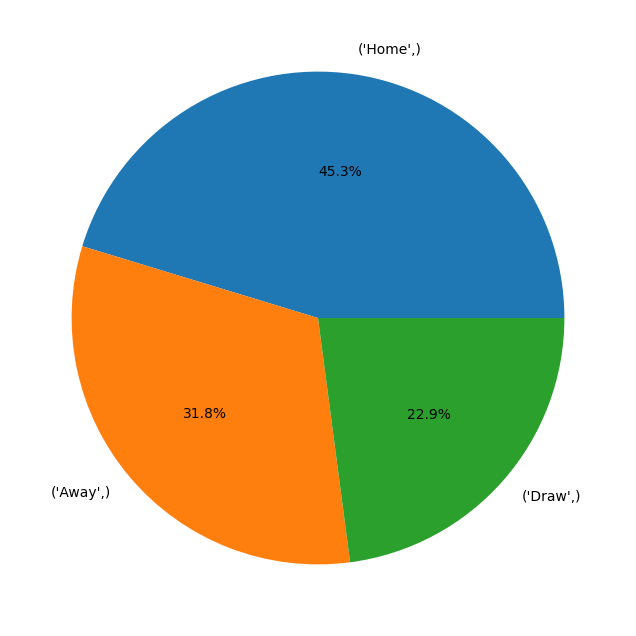

In [22]:
plt.figure(figsize= (8, 8))
plt.pie(fullTargetData.value_counts(), labels = fullTargetData.value_counts().index, autopct= '%1.1f%%')
plt.show()

On remarque alors une disparité des données : prêt de la moitié des matchs sont gagnés par l'équipe à domicile.

On va s'intéresser alors à certaines visualisation significatives pour notre problème.

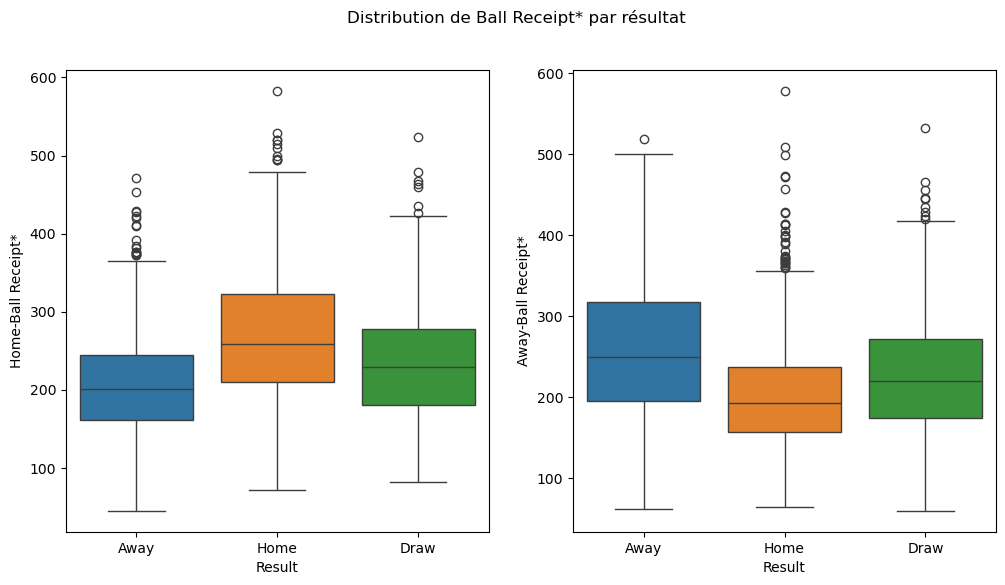

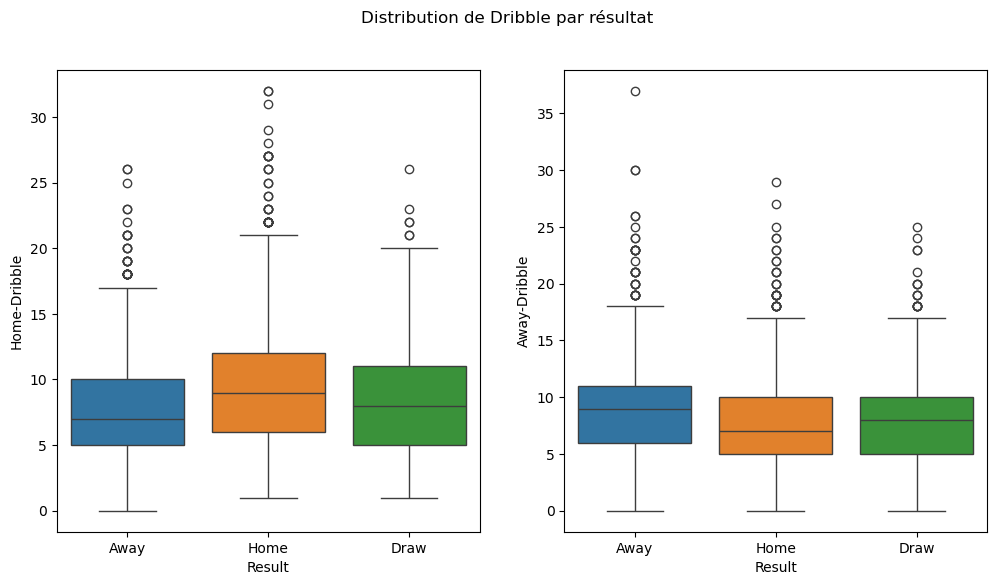

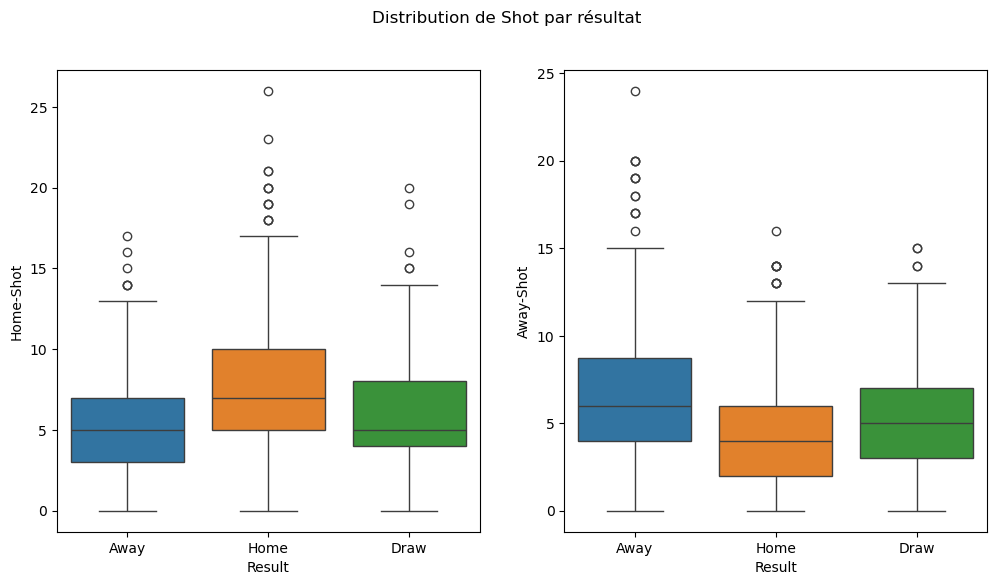

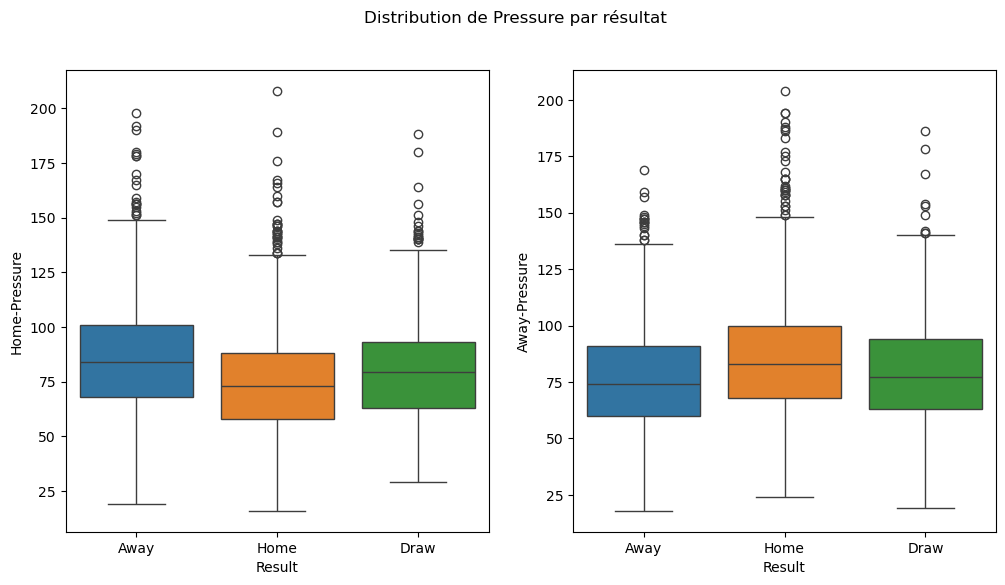

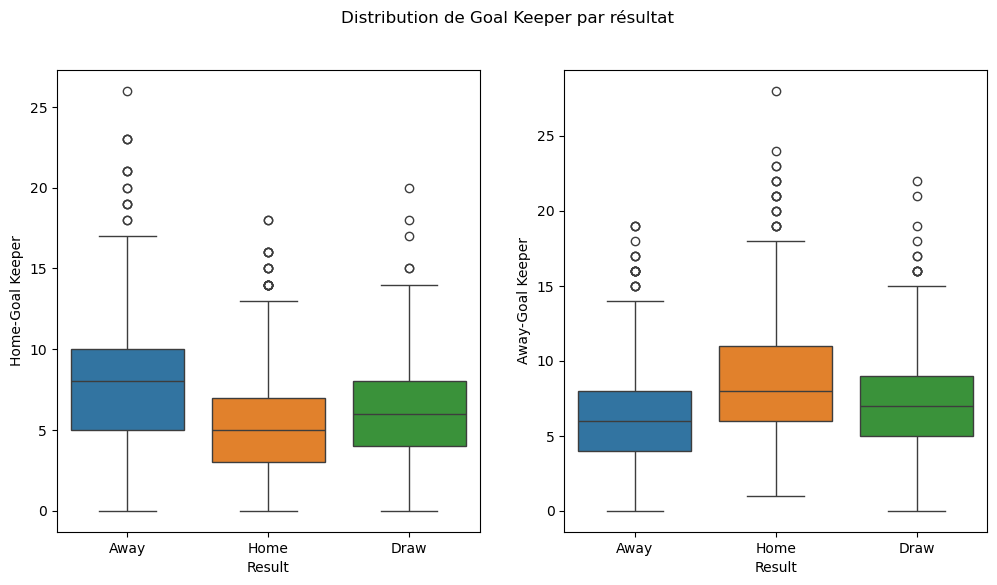

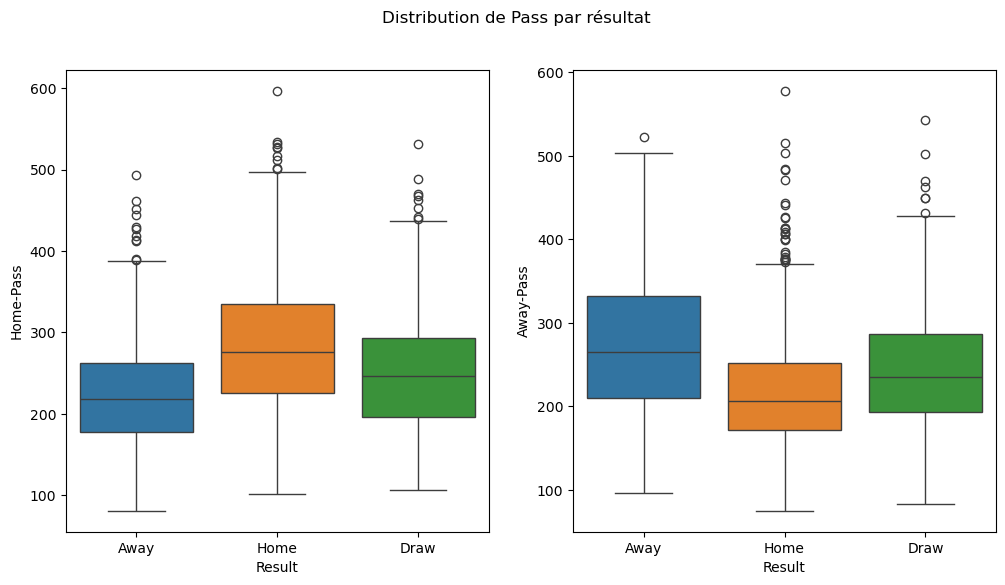

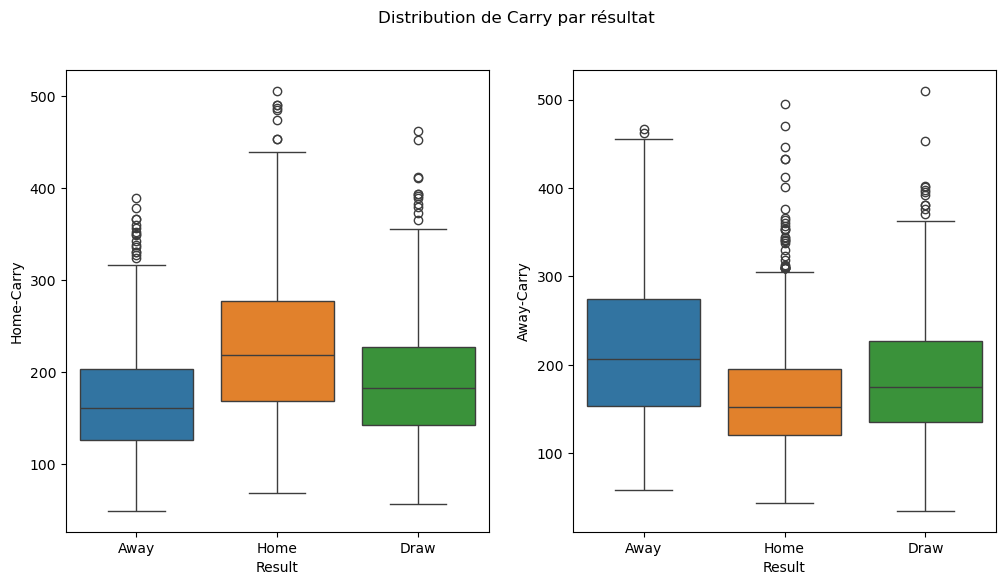

In [34]:
fullData = pd.concat([fullMatchData, fullTargetData], axis=1)

for eventType in ['Ball Receipt*', 'Dribble', 'Shot', 'Pressure', 'Goal Keeper', 'Pass', 'Carry']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

    sns.boxplot(y='Home-'+eventType, x='Result', data= fullData, hue = 'Result', ax= ax1)
    sns.boxplot(y='Away-'+eventType, x='Result', data= fullData, hue = 'Result', ax= ax2)
    plt.suptitle(f'Distribution de {eventType} par résultat')

Nous avons ici sélectionné les écarts les plus signifiants dans les représentations boxplots des variables en fonction du résultat.


On remarque alors que les variables les plus signifiantes sont sensiblement logiques dans le contexte : 
- Ball Receipt, Dribble, Pressure font surtout référence à une notion de possession de ballon ; en effet, plus une équipe possède le ballon, plus elle développe son jeu de passe et a sensiblement plus de chances de gagner le match ;
- L'autre aspect à considérer et l'aspect Shot, Goal Keeper ; plus le nombre de tirs et important, plus le nombre d'actions du Goal de l'équipe adverse est important (On retrouve ici la corrélation notée précédemment), plus l'équipe a de chance de gagner.

On suppose donc que les modèles évalués vont donner de l'importance à ses variables-ci.

# Modélisation

On commence par séparer notre jeu de test en jeu de test d'entraînement et de test, afin d'évaluer nos modèles après entraînement sur des données indépendantes.

In [50]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(fullMatchData, fullTargetData, stratify= fullTargetData, random_state=42)

# PCA

Avant d'implémenter les modèles et au vu du nombre importants de variabeles à notre disposition, regardons s'il est utile d'appliquer une PCA à notre dataset.

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
scl = StandardScaler()

pca.fit(scl.fit_transform(xTrain))

PCA()

Text(0, 0.5, 'Cumulative explained variance')

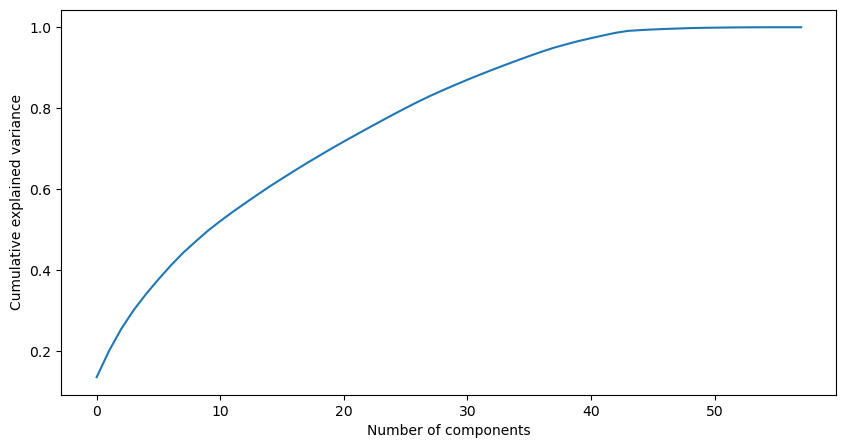

In [39]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Comme on peut le voir sur le graphique de la variance expliquée, on ne distingue aucun coude net permettant une PCA sgnificative. De plus, pour expliquer 95% de la variance initiale, il faudrait sélectionner 40 variables sur les 58 initiales. En effet les dernières valeurs (40 à 50) ne rajoute pas d'explication à la variance car elle sont identiquement corrélées. 

Les modèles suivants seront donc implémentés sans PCA préalable. En revanche, vu que les données ne sont pas à la même échelle, nous utiliserons un StandardScaler du package scikit-learn afin de normaliser les données.

## Modèles

Pour simplifier les études suivantes, nous implémenterons les modèles en utilisant le système de Pipeline de scikit-learn. Caque modèle sera donc défini par une pipeline comprenant un StandardScaler puis le modèle en question avec ses paramètres par défaut. Ces modèles seront ensuite stockés dans un dictionnaire, et seul les plus performants seront sélectionnés pour être optimisés. On se basera pour cela sur la métrique d'accuracy du package scikit-learn.

Nous implémenterons les différents modèles de classification multi-classes disponibles dans le package scikit-leanr, soit :
- RandomForest ;
- LogisticRegression ;
- SVC ;
- Gradient Bossting ;
- XGBoost Classifier.

In [51]:
#Import libraries
from sklearn.metrics import accuracy_score

from sklearn import (
    datasets,
    decomposition,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)

In [52]:
###Logistic Regression Pipeline

from sklearn.linear_model import LogisticRegression

pipeLogisticRegression = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression())
])

In [53]:
###RandomForest Pipeline

from sklearn.ensemble import RandomForestClassifier

pipeRandomForest = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', RandomForestClassifier())
])

In [54]:
###SVC Pipeline

from sklearn.svm import SVC

pipeSVC = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC())
])

In [55]:
###Gradient Boosting Classifier Pipeline

from sklearn.ensemble import GradientBoostingClassifier

pipeGradientBoosting = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', GradientBoostingClassifier())
])

In [62]:
###XGBoost Classifier Pipeline

import xgboost as xgb

pipeXGBoost = pipeline.Pipeline([
    ('scl', StandardScaler()),
    ('clf', xgb.XGBClassifier(objective = 'multi:softmax', random_state=42))
])

In [65]:
models = {
    'Logistic Regression': pipeLogisticRegression,
    'Random Forest Classifier': pipeRandomForest,
    'SVC': pipeSVC,
    'Gradient Boosting Classifier': pipeGradientBoosting,
    'XGBoost Classifier' : pipeXGBoost
}

In [66]:
models_scores = [] ###list of model names + score

for idx, (name,model) in enumerate(models.items()):
    ###fitting model on the training set and computing the accuracy score
    model.fit(xTrain, yTrain)
    y_pred = model.predict(xTest)
    score = metrics.accuracy_score(y_pred, yTest)

    models_scores.append((name, score))

    sorted_models = sorted(models_scores, key=lambda x: x[1], reverse=True)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['Away' 'Draw' 'Home']

In [60]:
for rank, (model_names, score) in enumerate(sorted_models, start=1):
    print('\nRank #%s :' % rank)
    print('Estimator: %s' % model_names)
    print('Test set accuracy score for default params: %.3f ' % score)


Rank #1 :
Estimator: SVC
Test set accuracy score for default params: 0.566 

Rank #2 :
Estimator: Logistic Regression
Test set accuracy score for default params: 0.555 

Rank #3 :
Estimator: Gradient Boosting Classifier
Test set accuracy score for default params: 0.554 

Rank #4 :
Estimator: Random Forest Classifier
Test set accuracy score for default params: 0.533 


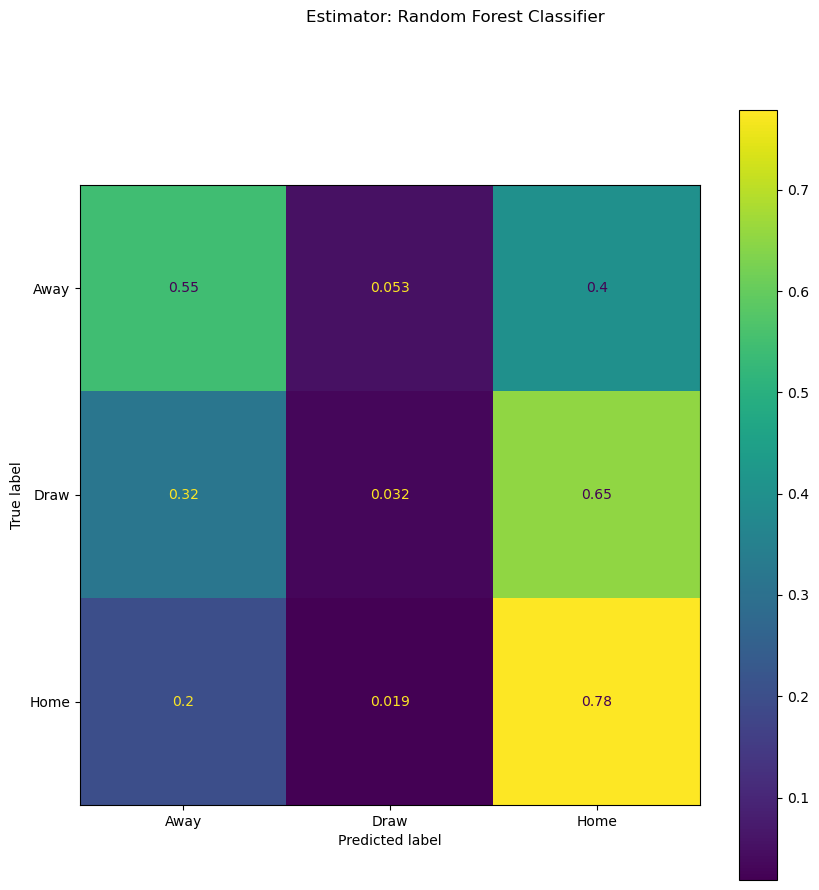

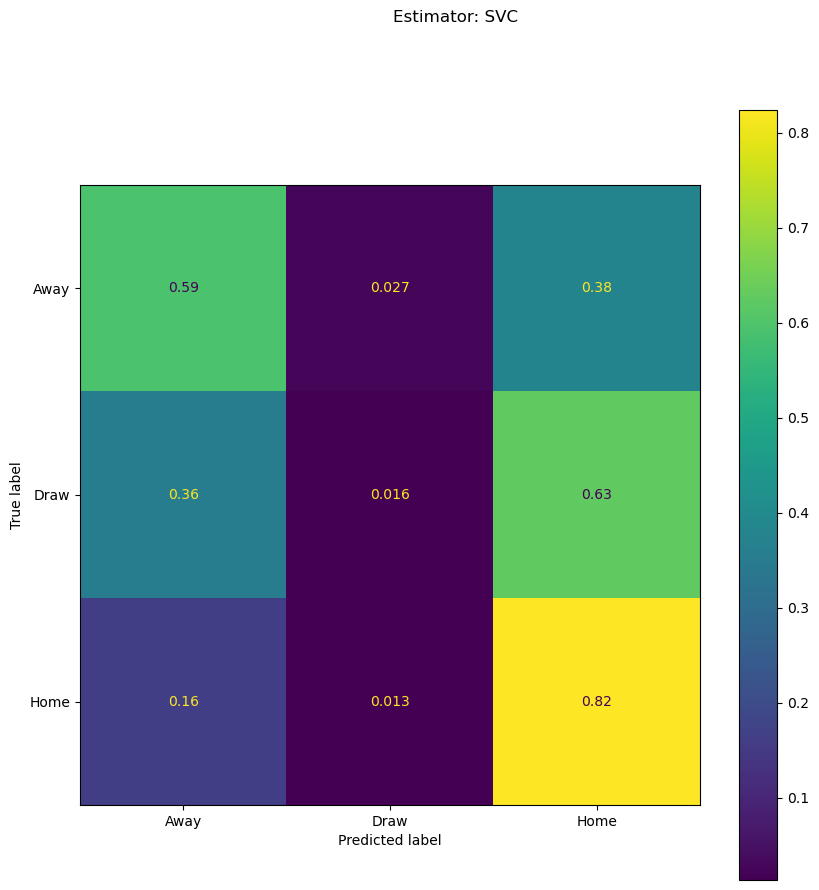

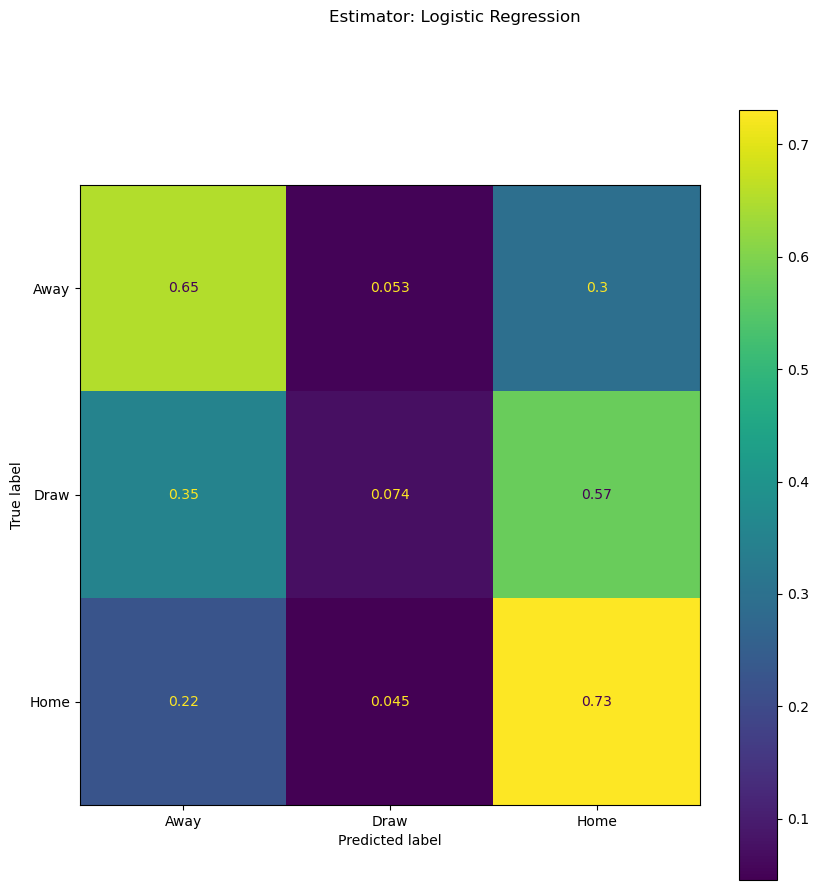

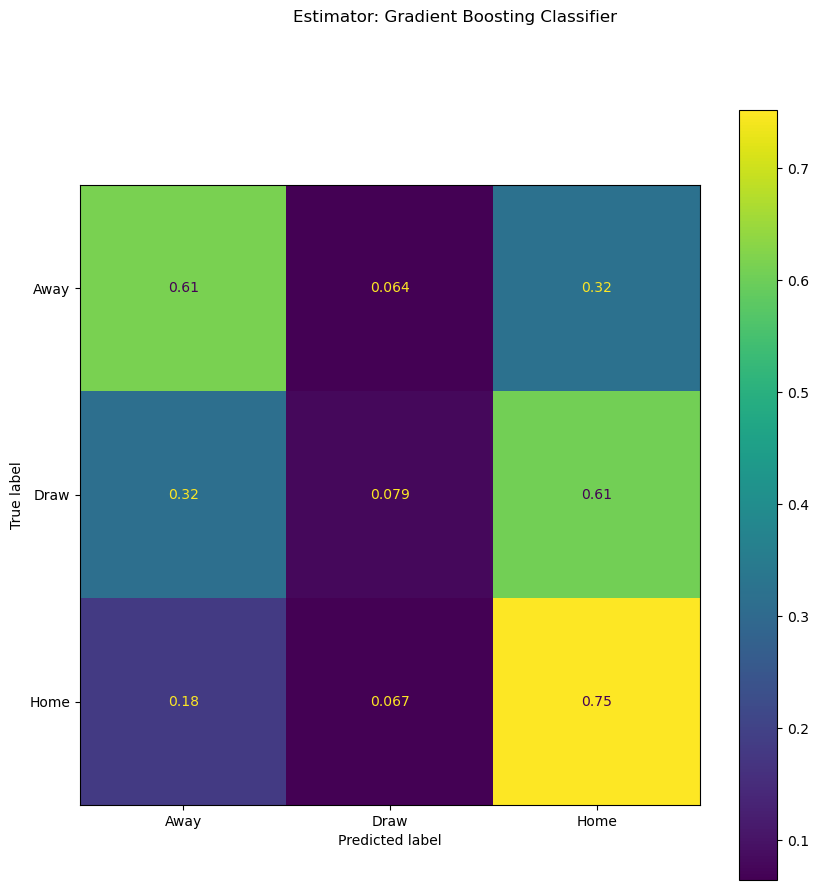

In [61]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

for idx, (name,model) in enumerate(models.items()):
    fig,ax = plt.subplots(figsize=(10,10))
    yPred = model.predict(xTest)
    fig.suptitle('Estimator: %s' % name)
    ConfusionMatrixDisplay.from_predictions(yTest, yPred, ax=ax, normalize= 'true')

## Métriques et résultats

CrossEntropyLoss

# Trucs à faire

    Boucle sur Compétitions pour créer dataframe plus gros

## Créer csv avec dataframe

Description des variables : 

Visualiaztion : Choix + Explication des Boxplots, Correlation matrix, 

Modèles : XGBoost/RandomForest/LogisticRegression

Métriques : accuracy_score, balanced_accuracy

TUning : Gridsearch/RandomizedSearch sur params

In [ ]:
matchStats['target'].value_counts()